# Graphical Causal Models (GCMs)

A graphical causal model consists of a causal direct acyclic graph (DAG) of variables and a causal mechanism for each of the variables. In other words, GCM aims at representing the true data generation process.

![Image](https://www.pywhy.org/dowhy/v0.11.1/_images/scm.png)

### Creating a GCM

In [111]:
%pip install dowhy
from dowhy import gcm
import networkx as nx
import matplotlib.pyplot as plt
from dowhy.utils import plot
from dowhy.gcm.causal_mechanisms import FunctionalCausalModel
import numpy as np
import pandas as pd



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


#### Setting the DAG

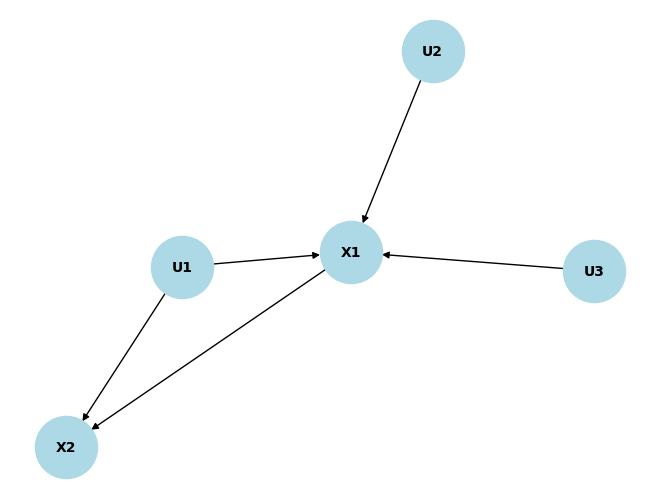

In [112]:
causal_graph = nx.DiGraph([
    ("U1", "X1"),
    ("U2", "X1"),
    ("U3", "X1"),
    ("X1", "X2"),
    ("U1", "X2")
])
causal_model = gcm.StructuralCausalModel(causal_graph)

nx.draw(causal_graph, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

#### Setting the causal mechanisms

In [113]:
causal_model.set_causal_mechanism('U1', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('U2', gcm.EmpiricalDistribution())
causal_model.set_causal_mechanism('U3', gcm.EmpiricalDistribution())

class X1Model(FunctionalCausalModel):
    def fit(self, X, Y):
        # No parameters to fit for this deterministic function
        pass

    def predict(self, X):
        # Use evaluate and draw_noise_samples to generate predictions
        noise = self.draw_noise_samples(len(X))
        return self.evaluate(X, noise)

    def evaluate(self, X, noise):
        # X[:, 0], X[:, 1], X[:, 2] correspond to U1, U2, U3 respectively
        U1 = X[:, 0]
        U2 = X[:, 1]
        U3 = X[:, 2]
        return np.round(((1 - U1) * U2 * U3 + noise)).astype(int)

    def draw_noise_samples(self, num_samples):
        # Generate noise samples
        return np.random.normal(loc=0, scale=0.0001, size=num_samples)

    def clone(self):
        # Return a new instance of this model
        return X1Model()

class X2Model(FunctionalCausalModel):
    def fit(self, X, Y):
        # No parameters to fit for this deterministic function
        pass

    def predict(self, X):
        # Use evaluate and draw_noise_samples to generate predictions
        noise = self.draw_noise_samples(len(X))
        return self.evaluate(X, noise)

    def evaluate(self, X, noise):
        # X[:, 0], X[:, 1] correspond to X1 and U1 respectively
        X1 = X[:, 0]
        U1 = X[:, 1]
        return np.round((X1 + U1 - X1 * U1 + noise)).astype(int)

    def draw_noise_samples(self, num_samples):
        # Generate noise samples
        return np.random.normal(loc=0, scale=0.0001, size=num_samples)

    def clone(self):
        # Return a new instance of this model
        return X2Model()

# Set custom causal mechanisms for X1 and X2
causal_model.set_causal_mechanism('X1', X1Model())
causal_model.set_causal_mechanism('X2', X2Model())

# Generate synthetic data
n_samples = 1000

# Generate U1, U2, U3 as random binary variables (Bernoulli with p=0.5)
U1 = np.random.binomial(1, 0.5, n_samples)
U2 = np.random.binomial(1, 0.5, n_samples)
U3 = np.random.binomial(1, 0.5, n_samples)

#### Generating data

In [114]:
# Number of samples to generate
n_samples = 1000

# Generate U1, U2, U3 as random binary variables (Bernoulli with p=0.5)
U1 = np.random.binomial(1, 0.5, n_samples)
U2 = np.random.binomial(1, 0.5, n_samples)
U3 = np.random.binomial(1, 0.5, n_samples)

# Define X1 and X2 according to the causal mechanisms
X1 = (1 - U1.astype(int)) * U2.astype(int) * U3.astype(int)
X2 = X1 + U1.astype(int) - X1 * U1.astype(int)

# Convert boolean values to integers (0 or 1)
X1 = X1.astype(int)
X2 = X2.astype(int)

# Create a DataFrame to store the dataset
data = pd.DataFrame({
    'U1': U1,
    'U2': U2,
    'U3': U3,
    'X1': X1,
    'X2': X2
})
data = data.astype(int)

# Display the first few rows of the dataset
print(data.head())



   U1  U2  U3  X1  X2
0   1   1   0   0   1
1   0   1   1   1   1
2   0   1   0   0   0
3   0   0   1   0   0
4   0   0   0   0   0


#### Fitting the model and generating new data

In [115]:
gcm.fit(causal_model, data)
generated_data = gcm.draw_samples(causal_model, num_samples=1000)
print(generated_data.head())

Fitting causal mechanism of node X2: 100%|██████████| 5/5 [00:00<00:00, 655.34it/s]

   U1  U2  U3  X1  X2
0   1   0   0   0   1
1   1   0   0   0   1
2   1   0   0   0   1
3   0   0   0   0   0
4   1   0   0   0   1


#### Calculating the ATE

In [116]:
gcm.average_causal_effect(causal_model,
                         'X2',
                         interventions_alternative={'X1': lambda x: 1},
                         interventions_reference={'X1': lambda x: 0},
                         num_samples_to_draw=1000)